# FIT5202 Assignment 2A : Building models to predict future eCommerce sales

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Customer Segmentation and Knowledge sharing with K-Mean](#part-3)
    * [Part 4 : Data Ethics, Privacy, and Security](#part-4)
 
Please add code/markdown cells as you need.

# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you will need to load the given datasets into PySpark DataFrames and use DataFrame functions to process the data. Usage of Spark SQL is discouraged, and your can only use pandas to format results. For plotting, different visualisation packages can be used, but please ensure that you have included instructions to install the additional packages and the installation will be successful in the provided docker container(in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size not exceed 20MB, and to run locally with all CPU cores on your machine (note: if you have insufficient RAM, reducing the number of cores is also acceptable.)

In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession 
from pyspark import SparkContext



master = "local[*]"
app_name = "MOTH TradeHub"
max_partition_size = ""

spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.files.maxPartitionBytes", 20 * 1024 * 1024)

spark = SparkSession.builder.config(conf= spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

1.1.2 Write code to define the schemas for category, customer, product, clickstream and transaction datasets, following the data types suggested in the metadata file.

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, DateType

In [3]:
# predefine all schemas
category_schema = StructType([
    StructField("#", StringType(), True),
    StructField("category_id", StringType(), True),
    StructField("cat_level1", StringType(), True),
    StructField("cat_level2", StringType(), True),
    StructField("cat_level3", StringType(), True)
])


customer_schema = StructType([
    StructField("#", StringType(), True),  
    StructField("customer_id", StringType(), True),
    StructField("first_name", StringType(), True),
    StructField("last_name", StringType(), True),
    StructField("user_name", StringType(), True),
    StructField("email", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("birthdate", DateType(), True),
    StructField("device_type", StringType(), True),
    StructField("device_id", StringType(), True),
    StructField("device_version", StringType(), True),
    StructField("home_location_lat", FloatType(), True),
    StructField("home_location_long", FloatType(), True),
    StructField("home_location", StringType(), True),
    StructField("home_country", StringType(), True),
    StructField("first_join_date", DateType(), True)
])

product_schema = StructType([
    StructField("#", StringType(), True),
    StructField("id", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("baseColour", StringType(), True),
    StructField("season", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("usage", StringType(), True),
    StructField("productDisplayName", StringType(), True),
    StructField("category_id", StringType(), True)
])


click_stream_schema = StructType([
    StructField("#", StringType(), True),
    StructField("session_id", StringType(), True),
    StructField("event_name", StringType(), True),
    StructField("event_time", TimestampType(), True),
    StructField("event_id", StringType(), True),
    StructField("traffic_source", StringType(), True),
    StructField("event_metadata", StringType(), True)
])


transaction_schema = StructType([
    StructField("#", StringType(), True),
    StructField("created_at", TimestampType(), True),
    StructField("customer_id", StringType(), True),
    StructField("booking_id", StringType(), True),
    StructField("session_id", StringType(), True),
    StructField("product_metadata", StringType(), True),
    StructField("payment_method", StringType(), True),
    StructField("payment_status", StringType(), True),
    StructField("promo_amount", FloatType(), True),
    StructField("promo_code", StringType(), True),
    StructField("shipment_fee", FloatType(), True),
    StructField("shipment_date_limit", TimestampType(), True),
    StructField("shipment_location_lat", FloatType(), True),
    StructField("shipment_location_long", FloatType(), True),
    StructField("total_amount", FloatType(), True)
])

1.1.3 Using predefined schema, write code to load the csv files into separate dataframes. Print the schemas of all dataframes.

In [4]:
# loading all files and use predefined schemas
df_category = spark.read.csv("category.csv", header= True, schema= category_schema, escape= '"')
df_customer = spark.read.csv("customer.csv", header= True, schema= customer_schema, escape= '"')
df_product = spark.read.csv("product.csv", header= True, schema= product_schema, escape= '"')
df_click_stream = spark.read.csv("click_stream.csv", header= True, schema= click_stream_schema)
df_transactions = spark.read.csv("new_transactions.csv", header= True, schema= transaction_schema, escape= '"')

In [7]:
df_click_stream.select("event_time").show(5, truncate=False)

+--------------------------+
|event_time                |
+--------------------------+
|2019-09-06 15:54:32.821085|
|2019-09-06 16:03:57.821085|
|2019-09-01 12:05:10.322763|
|2019-09-01 12:06:33.322763|
|2019-09-01 12:07:00.322763|
+--------------------------+
only showing top 5 rows



In [5]:
df_category.printSchema()

root
 |-- #: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- cat_level1: string (nullable = true)
 |-- cat_level2: string (nullable = true)
 |-- cat_level3: string (nullable = true)



In [6]:
df_customer.printSchema()

root
 |-- #: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: date (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_version: string (nullable = true)
 |-- home_location_lat: float (nullable = true)
 |-- home_location_long: float (nullable = true)
 |-- home_location: string (nullable = true)
 |-- home_country: string (nullable = true)
 |-- first_join_date: date (nullable = true)



In [7]:
df_product.printSchema()

root
 |-- #: string (nullable = true)
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- baseColour: string (nullable = true)
 |-- season: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- usage: string (nullable = true)
 |-- productDisplayName: string (nullable = true)
 |-- category_id: string (nullable = true)



In [8]:
df_click_stream.printSchema()

root
 |-- #: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- event_name: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_id: string (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- event_metadata: string (nullable = true)



In [9]:
df_transactions.printSchema()

root
 |-- #: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- booking_id: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- product_metadata: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- payment_status: string (nullable = true)
 |-- promo_amount: float (nullable = true)
 |-- promo_code: string (nullable = true)
 |-- shipment_fee: float (nullable = true)
 |-- shipment_date_limit: timestamp (nullable = true)
 |-- shipment_location_lat: float (nullable = true)
 |-- shipment_location_long: float (nullable = true)
 |-- total_amount: float (nullable = true)



### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
In the clickstream dataset, there are 9 types of events:  
VIEW_PROMO, SCROLL, ADD_PROMO, VIEW_ITEM, CLICK, PURCHASE, ADD_TO_CART, HOMEPAGE, SEARCH  
We categorize them into 3 different categories:  
Category 1(high value actions - highly likely to purchase): ADD_PROMO, ADD_TO_CART  
Category 2(medium value actions - likely to purchase): VIEW_PROMO, VIEW_ITEM, SEARCH  
Category 3(low value actions - just browsing):  SCROLL, HOMEPAGE, CLICK  
Perform the following tasks base on the clickstream dataframe and create a new dataframe.  

In [10]:
# define udf for converting event names to categorical values 
def cat_event(data):
    """
    This function is use for converting event name to categorical values
    """
    cat_1 = ["ADD_PROMO", "ADD_TO_CART"]
    cat_2 = ["VIEW_PROMO", "VIEW_ITEM", "SEARCH"]
    cat_3 = ["SCROLL", "HOMEPAGE", "CLICK"]
    
    # create conditions for converting
    if data in cat_1:
        return "Category 1"
    elif data in cat_2:
        return "Category 2"
    elif data in cat_3:
        return "Category 3"

In [11]:
# register udf function to pyspark dataframe
cat_event_udf = F.udf(cat_event, StringType())
# apply udf function to the data frame
feature_df = df_click_stream.withColumn("event_cat", cat_event_udf(df_click_stream["event_name"]))
# drop if event_cat == na
feature_df = feature_df.dropna(subset=["event_cat"])

In [12]:
feature_df.show(5)

+---+--------------------+-----------+--------------------+--------------------+--------------+--------------------+----------+
|  #|          session_id| event_name|          event_time|            event_id|traffic_source|      event_metadata| event_cat|
+---+--------------------+-----------+--------------------+--------------------+--------------+--------------------+----------+
|  1|fb0abf9e-fd1a-44d...|   HOMEPAGE|2019-09-06 15:54:...|9c4388c4-c95b-467...|        MOBILE|                null|Category 3|
|  2|fb0abf9e-fd1a-44d...|     SCROLL|2019-09-06 16:03:...|4690e1f5-3f99-42d...|        MOBILE|                null|Category 3|
|  3|7d440441-e67a-4d3...|   HOMEPAGE|2019-09-01 12:05:...|88aeaeb5-ec98-485...|        MOBILE|                null|Category 3|
|  4|7d440441-e67a-4d3...|ADD_TO_CART|2019-09-01 12:06:...|934e306e-ecc6-472...|        MOBILE|{'product_id': 15...|Category 1|
|  5|7d440441-e67a-4d3...|     SEARCH|2019-09-01 12:07:...|c952142b-4fe9-469...|        MOBILE|{'search_

1.2.1 For each unique session_id, count the number of actions in each category and create 3 columns(num_cat_highvalue, num_cat_midvalue, num_cat_lowvalue).

In [13]:
# counting the number of each category in each session
feature_df = feature_df.groupBy("session_id", "event_cat").count()

# change data from long to wide format
feature_df = feature_df.groupBy("session_id").pivot("event_cat").sum("count")

# change columns names
feature_df = feature_df.withColumnRenamed("Category 1", "num_cat_highvalue")\
                           .withColumnRenamed("Category 2", "num_cat_midvalue")\
                           .withColumnRenamed("Category 3", "num_cat_lowvalue")

# fill null in each
feature_df = feature_df.fillna(0)

In [14]:
feature_df.show(5)

+--------------------+-----------------+----------------+----------------+
|          session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|
+--------------------+-----------------+----------------+----------------+
|e7f689a1-28a0-4fe...|                1|               1|               3|
|30f85513-ceae-452...|                1|               2|               2|
|5ed58b7b-2382-4fc...|                2|              10|              17|
|e855274d-543d-482...|                2|               2|               8|
|7f2c9a70-a5d1-478...|                2|               5|              12|
+--------------------+-----------------+----------------+----------------+
only showing top 5 rows



1.2.2. Create 2 columns with percentage ratio of high value action and low value actions. (i.e. high value ratio = (count of high value actions)/(total actions) * 100%)

In [15]:
# create new column sum_actions
feature_df = feature_df.withColumn("sum_actions", F.expr("num_cat_highvalue + num_cat_midvalue + num_cat_lowvalue"))

# create high and low values ratio
feature_df = feature_df.withColumn("high_value_ratio", F.expr("num_cat_highvalue / sum_actions"))
feature_df = feature_df.withColumn("low_value_ratio", F.expr("num_cat_lowvalue / sum_actions"))

In [16]:
feature_df.show(5)

+--------------------+-----------------+----------------+----------------+-----------+-------------------+------------------+
|          session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|sum_actions|   high_value_ratio|   low_value_ratio|
+--------------------+-----------------+----------------+----------------+-----------+-------------------+------------------+
|e7f689a1-28a0-4fe...|                1|               1|               3|          5|                0.2|               0.6|
|30f85513-ceae-452...|                1|               2|               2|          5|                0.2|               0.4|
|5ed58b7b-2382-4fc...|                2|              10|              17|         29|0.06896551724137931|0.5862068965517241|
|e855274d-543d-482...|                2|               2|               8|         12|0.16666666666666666|0.6666666666666666|
|7f2c9a70-a5d1-478...|                2|               5|              12|         19|0.10526315789473684| 0.631578947

1.2.3 Create a new column “is_promotion” with value of 1 or 0 and add to feature_df. If there are “ADD_PROMO” actions in a session, set it to 1, otherwise 0.

In [17]:
# create new column consist of only ADD_PROMO
df_is_promo = df_click_stream.filter(F.col("event_name") == "ADD_PROMO")

# join dataframe feature_df and df_promotion
feature_df = feature_df.join(df_is_promo.select("session_id", "event_name"), on="session_id", how= "left")

# create new column "is_protion" and assign boolean value 0,1
feature_df = feature_df.withColumn("is_promotion", F.when(F.col("event_name") == "ADD_PROMO", "1")\
                                       .otherwise("0")).drop("event_name")

In [18]:
feature_df.select("is_promotion").show(5)

+------------+
|is_promotion|
+------------+
|           1|
|           0|
|           0|
|           0|
|           1|
+------------+
only showing top 5 rows



1.2.4 For each unique session_id, base on event_time, extract the season. (note: The dataset is from Indonesia, Spring: Mar-May, Summer: Jun-Aug, Autumn: Sep-Nov, Winter: Dec-Feb)

In [19]:
# import calendar library
import calendar

In [20]:
# create udf for converting moths to seasons
def convert_month_season(data):
    """
    input: date
    output: season for particular month
    description: The function is used for converting month to season
    """
    # extract month from date
    month = data.month
    
    # create conditions for each month
    if month in (3, 4, 5):
        return "Spring"
    elif month in (6, 7, 8):
        return "Summer"
    elif month in (9, 10, 11):
        return "Autumn"
    elif month in (12, 1, 2):
        return "Winter"

In [21]:
# register convert_month_season to dataframe
convert_month_season_udf = F.udf(convert_month_season, StringType())

# group session_id and find the max time
df_season = df_click_stream.groupBy("session_id").agg(F.max("event_time").alias("event_time"))

# apply convert_month_season to the event_time, assign to season
df_season = df_season.withColumn("season", convert_month_season_udf(F.col("event_time"))).select("session_id", "season")

# join feature_df and df_season
feature_df = feature_df.join(df_season, on="session_id", how= "left")

In [22]:
feature_df.select("season").show(5)

+------+
|season|
+------+
|Autumn|
|Spring|
|Summer|
|Spring|
|Winter|
+------+
only showing top 5 rows



1.2.5 Join tables to find customer information and add columns to feature_df: gender, age, device type, home_location, first join year. (note: For some column, you need to perform transformation. For age, keep integer only.)

In [23]:
# loading customer_session
df_customer_session = spark.read.csv("customer_session.csv", header=True, inferSchema=True, escape= '"')

In [24]:
# the number of distinct session id in df_customer_session != session id
feature_df = feature_df.join(df_customer_session, on= "session_id", how= "left")

# create customer_info dataframe
customer_info = df_customer\
            .select("customer_id", "gender", "birthdate", "device_type", "home_location", "first_join_date", "device_version")

# create new column age then drop birthdate
customer_info = customer_info.withColumn("age", F.floor(F.datediff(F.current_date(), F.col("birthdate")) / 365.25)\
                                         .cast("integer")).drop("birthdate")

# extract first_join_year from first_join_date
customer_info = customer_info.withColumn("first_join_year", F.year(F.col("first_join_date")))\
                                        .drop("first_join_date")

# join feature_df and custoemr_info
feature_df = feature_df.join(customer_info, on= "customer_id", how= "left")

# drop unwanted columns
feature_df = feature_df.drop("sum_actions", "#")

In [25]:
feature_df.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- session_id: string (nullable = true)
 |-- num_cat_highvalue: long (nullable = true)
 |-- num_cat_midvalue: long (nullable = true)
 |-- num_cat_lowvalue: long (nullable = true)
 |-- high_value_ratio: double (nullable = true)
 |-- low_value_ratio: double (nullable = true)
 |-- is_promotion: string (nullable = false)
 |-- season: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- home_location: string (nullable = true)
 |-- device_version: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- first_join_year: integer (nullable = true)



1.2.6 Join tables to find out if the customer made purchase or not, and add to feature_df as 1 or 0. We will use this column as training label later.

In [26]:
# find status of purchase from transction payment_status
df_pur = df_transactions.select("session_id", "payment_status").filter(F.col("payment_status") == "Success")

# join feature_df and df_pur
feature_df = feature_df.join(df_pur, on= "session_id", how= "left")

# create new column is_purchase and assign value based on payment status then drop payment_status and customer_id
feature_df = feature_df.withColumn("is_purchase", F.when(F.col("payment_status") == "Success", "1")\
                                   .otherwise("0")).drop("payment_status", "customer_id")

In [27]:
feature_df.select("is_purchase").show(5)

+-----------+
|is_purchase|
+-----------+
|          1|
|          1|
|          0|
|          1|
|          1|
+-----------+
only showing top 5 rows



### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
**1.3.1 With the feature_df, write code to show the basic statistics: a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile; b)For each non-numeric column, display the top-5 values and the corresponding counts; c) For each boolean column, display the value and count.**

In [28]:
# import libaries for plotting 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

 **a)** For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile;

In [29]:
# get columns names and data type of each column
col_data_type = feature_df.dtypes

# for storing expression
summary_expression = []

# loop columns and use only numerical columns
for col_name, col_type in col_data_type:
    if col_type in ("bigint", "double", "int"):
        summary_expression.extend([
        F.count(col_name).alias(f"{col_name}_count"), # find count of each column
        F.mean(col_name).alias(f"{col_name}_mean"),   # find mean of each column
        F.stddev(col_name).alias(f"{col_name}_stddev"),  # find std of each column
        F.min(col_name).alias(f"{col_name}_min"),  # find min of each column
        F.max(col_name).alias(f"{col_name}_max"),  # find max of each column
        F.expr(f"percentile({col_name}, 0.25)").alias(f"{col_name}_25_percentile"), # find 25 percentile 
        F.expr(f"percentile({col_name}, 0.50)").alias(f"{col_name}_50_percentile"), # find 50 percentile
        F.expr(f"percentile({col_name}, 0.75)").alias(f"{col_name}_75_percentile") # find 0.75 percentile
        ])

# apply summary_expression to feature_df and turn it to dict
summary_dict = feature_df.agg(*summary_expression).collect()[0].asDict()        

In [30]:
# print all summary information of numerical columns
for key, value in summary_dict.items():
    print(key, value)

num_cat_highvalue_count 895203
num_cat_highvalue_mean 2.528691257737072
num_cat_highvalue_stddev 2.2999561060121847
num_cat_highvalue_min 0
num_cat_highvalue_max 53
num_cat_highvalue_25_percentile 1.0
num_cat_highvalue_50_percentile 2.0
num_cat_highvalue_75_percentile 3.0
num_cat_midvalue_count 895203
num_cat_midvalue_mean 3.4278180479734766
num_cat_midvalue_stddev 4.475989272102879
num_cat_midvalue_min 0
num_cat_midvalue_max 157
num_cat_midvalue_25_percentile 1.0
num_cat_midvalue_50_percentile 2.0
num_cat_midvalue_75_percentile 5.0
num_cat_lowvalue_count 895203
num_cat_lowvalue_mean 7.4270696143779675
num_cat_lowvalue_stddev 9.239566040509864
num_cat_lowvalue_min 1
num_cat_lowvalue_max 512
num_cat_lowvalue_25_percentile 2.0
num_cat_lowvalue_50_percentile 5.0
num_cat_lowvalue_75_percentile 9.0
high_value_ratio_count 895203
high_value_ratio_mean 0.26122778985537803
high_value_ratio_stddev 0.17578152673812247
high_value_ratio_min 0.0
high_value_ratio_max 0.9666666666666667
high_value_rat

**b)** For each non-numeric column, display the top-5 values and the corresponding counts.

In [31]:
# dispay non-numeric and show top5 counting 
for col_name, col_type in col_data_type:
    if col_type not in ("bigint", "double", "int") and col_name not in ("is_promotion", "is_purchase"):
        feature_df.select(col_name).groupBy(col_name).count().orderBy("count",ascending=False).show(5)

+--------------------+-----+
|          session_id|count|
+--------------------+-----+
|000130b9-07d1-437...|    1|
|00007415-e0e7-4a3...|    1|
|0000a158-a793-4f6...|    1|
|000593e4-535e-43f...|    1|
|00008e68-a4d4-4b5...|    1|
+--------------------+-----+
only showing top 5 rows

+------+------+
|season| count|
+------+------+
|Spring|244427|
|Summer|234689|
|Winter|215604|
|Autumn|200483|
+------+------+

+------+------+
|gender| count|
+------+------+
|     F|543509|
|     M|309073|
|  null| 42621|
+------+------+

+-----------+------+
|device_type| count|
+-----------+------+
|    Android|656809|
|        iOS|195773|
|       null| 42621|
+-----------+------+

+-------------+------+
|home_location| count|
+-------------+------+
| Jakarta Raya|156698|
|   Jawa Barat|101244|
|  Jawa Tengah| 95240|
|   Jawa Timur| 81106|
|   Yogyakarta| 66444|
+-------------+------+
only showing top 5 rows

+--------------+-----+
|device_version|count|
+--------------+-----+
|          null|42621|


**c)** For each boolean column, display the value and count.

In [32]:
# show count of is_promotion and is_purchase
feature_df.select("is_promotion").groupBy("is_promotion").count().show()
feature_df.select("is_purchase").groupBy("is_purchase").count().show()

+------------+------+
|is_promotion| count|
+------------+------+
|           0|568668|
|           1|326535|
+------------+------+

+-----------+------+
|is_purchase| count|
+-----------+------+
|          0|367391|
|          1|527812|
+-----------+------+



**1.3.2 Explore the dataframe and write code to present two plots worthy of presentation to the company, describe your plots and discuss the findings from the plots.**
- One of the plots needs to base on feature_df, you’re free to choose the other one.  
- Hint: you can use the basic plots (e.g., histograms, line charts, scatter plots) for the relationship between a column and the label; or more advanced plots like correlation plots; 2: if your data is too large for the plotting, consider using sampling before plotting.  
- 150 words max for each plot’s description and discussion  
- Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc.  
- Please only use the provided data for visualisation  


**First plot**

Text(0, 0.5, 'Count')

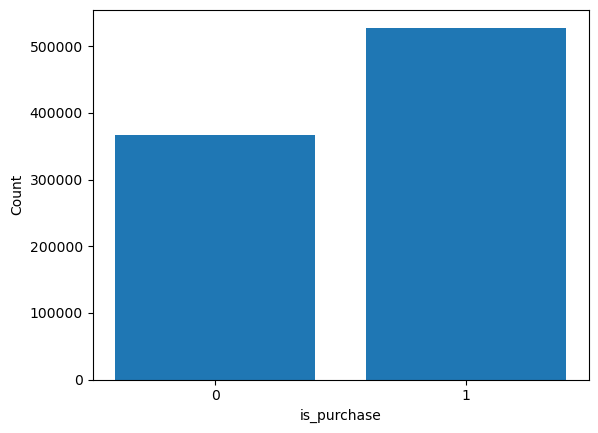

In [33]:
# create dataframe for plotting
count_is_purchase = feature_df.groupBy("is_purchase").count().toPandas()
# plot bar chart
plt.bar(count_is_purchase['is_purchase'], count_is_purchase['count'])
plt.xlabel('is_purchase')
plt.ylabel('Count')

**Discussion**\
The aim of the task is to predict the "is_purchase" based on the data for each customer. In a classification task, achieving class balance is crucial as it significantly impacts the quality of classification performance. When classes are highly imbalanced, there is a risk of poor classification performance, as the model tends to favor predicting the more frequently occurring class. From the visualisation, we can clearly see that the preidicted classes are slightly imbalance which is insignificant for classification task. Hence, the classification can be directly trained by this data without gather more customer data.

**Second plot**

In [34]:
# create dataframe for plotting
transaction_info = df_transactions.select("session_id", "total_amount", "shipment_fee")
transaction_info = feature_df.join(transaction_info, on= "session_id", how= "left").toPandas()
sum_data = transaction_info.groupby(["age", "is_purchase"]).sum("total_amount")

<Axes: xlabel='age', ylabel='total_amount'>

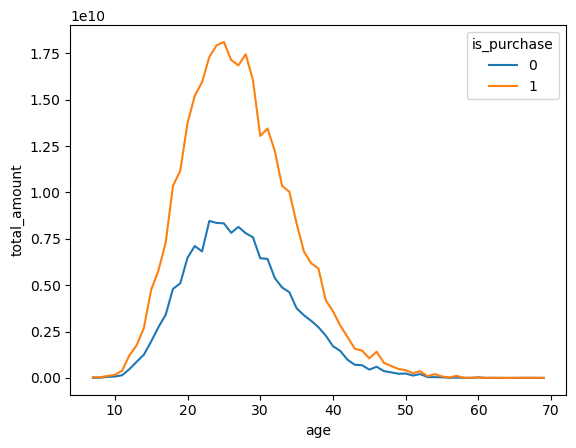

In [35]:
# potting line chart
sns.lineplot(data= sum_data ,x= "age", y= "total_amount", hue= "is_purchase")

**Discussion**\
From the line chart, it's evident that the spending on purchases increases with age, the purchasing total amount is peaking at around 25 years old, then declining rapidly and saturating after the age of 50. Notably, the purchasing amount consistently exceeds the non-purchasing amount across all age groups. Furthermore, the chart suggests that MOTH's primary marketing focus appears to be on the age group of 20-30. To boost sales, the company may need to allocate more attention to targeting other age demographics.

## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you will need to use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, would receive zero marks. Excessive usage of Spark SQL is discouraged.
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the situation we have, discuss the importance of those features (For example, which features may be useless and should be removed, which feature has a great impact on the label column, which should be transformed) which features you are planning to use? Discuss the reasons for selecting them and how you create/transform them
- 300 words max for the discussion
- Please only use the provided data for model building
- You can create/add additional feature/column based on the dataset
- Hint - things to consider include whether to create more feature columns, whether to remove some columns, using the insights from the data exploration/domain knowledge/statistical models  

**Selected features**
  1. high_value_ratio, low_value_ration: It is calucalte from high and low impotance behavior, so I think it will help the prediction.
  2. is_promotion: From the EDA process, custoemer tend to buy product when there is promotion.
  3. season: EDA suggests that there might be seasonality pattern on purchasing activity.
  4. gender: EDA suggests that female purchasing level is much higher than male customers.
  5. device_type: Activity of between device types show sinificant level different of activity level.
  6. home_location: From EDA, we can see most purchasing activities are in just a few major cities. 
  7. age: The plot from 1.3.2 show that there is a claer pattern of purchasing level according to age.
  8. first_join_year: EDA, suggest that early customer tend to make more purchasing.
  9. payment_method: difficulites of differnt methid might have an effects on consumer behaviors.

**Remove features**
  1. session_id: Because, session_id is used for tracking users which will not provide any information related to customers purchased behavior.
  2. num_cat_highvalue, midvalue, lowvalue: Since, we already have the data of high_value_ratio, low_value_ration. It would be redundant if we use these features.
  3. device_version: since, we already have device_type so device_versio is redundant data.

In [36]:
from pyspark.sql.functions import isnan, when, count, col
feature_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in feature_df.columns]).show()

+----------+-----------------+----------------+----------------+----------------+---------------+------------+------+------+-----------+-------------+--------------+-----+---------------+-----------+
|session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|high_value_ratio|low_value_ratio|is_promotion|season|gender|device_type|home_location|device_version|  age|first_join_year|is_purchase|
+----------+-----------------+----------------+----------------+----------------+---------------+------------+------+------+-----------+-------------+--------------+-----+---------------+-----------+
|         0|                0|               0|               0|               0|              0|           0|     0| 42621|      42621|        42621|         42621|42621|          42621|          0|
+----------+-----------------+----------------+----------------+----------------+---------------+------------+------+------+-----------+-------------+--------------+-----+---------------+-----------+


2.1.2 Write code to create/transform the columns based on your discussion above
- Hint: You can use one dataframe for both two use cases(classification and k-mean later in part 3) since you can select your desired columns as the input and output for each use case. 


In [37]:
# adding payment method, total_amount
feature_df = feature_df\
            .join(df_transactions.select("session_id", "payment_method", "total_amount"), on= "session_id", how= "left")

# drop session_id
feature_df = feature_df.dropna().drop("session_id")

### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

**2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1, and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.
Please DO NOT fit/transform the data yet**

In [38]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [39]:
# factors => is_promotion, season, gender, device_type, home_location, is_purchase
catinput_cols = ["is_promotion", "season", "gender", "device_type", "home_location"]
catoutput_col = "is_purchase"
cat_cols = catinput_cols + [catoutput_col]
num_cols = ['high_value_ratio', 'low_value_ratio', 'age', 'first_join_year']

# define output index columns
output_cols = [f'{x}_index' for x in catinput_cols]
output_cols.append('label')
# initiate string indexer
input_indexer = StringIndexer(inputCols= cat_cols, outputCols= output_cols)

# define in/output for ohe
inputcols_OHE = [x for x in output_cols if x!='label']
outputcols_OHE = [f"{x}_vec" for x in catinput_cols]
# initiate ohe
encoder = OneHotEncoder(inputCols= inputcols_OHE, outputCols= outputcols_OHE)

# initiate assembler
assembler_input = outputcols_OHE + num_cols
assembler = VectorAssembler(inputCols= assembler_input, outputCol= "features")

# define each stage
stage_1 = input_indexer
stage_2 = encoder
stage_3 = assembler

In [40]:
# rf model
random_forest = RandomForestClassifier(labelCol= "label", featuresCol= "features", numTrees=100, seed=1)

In [41]:
# GBT classifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10, seed=1)

**2.2.2. Write code to include the above Transformers/Estimators into two pipelines.
Please DO NOT fit/transform the data yet**

In [42]:
# rf model pipe line
rf_stages = [stage_1, stage_2, stage_3, random_forest]
rf_pipeline = Pipeline(stages= rf_stages)

In [43]:
# GBT model pipe line
gbt_stages = [stage_1, stage_2, stage_3, gbt]
gbt_pipeline = Pipeline(stages= gbt_stages)

### 2.3 Preparing the training data and testing data  
Write code to split the data for training and testing purposes.  
Note: Due to the large size of the dataset, you can choose to use random sampling (say 20% of the dataset) and do a train/test split; or use one year of data for training and another year for testing. 

In [44]:
# change str to int
feature_df = feature_df.withColumn("is_purchase", F.col("is_purchase").cast(IntegerType()))

# sample data from main dataframe
sample_data = feature_df.sample(fraction= 0.2, seed= 1)
sample_data = sample_data.cache()

# train test split
train, test = sample_data.randomSplit([0.8, 0.2], seed= 1)

### 2.4 Training and evaluating models  
2.4.1 Write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to predict the testing data from 2.3

In [45]:
# fit pipelines
rf_pipline_model = rf_pipeline.fit(train)
gbt_pipeline_model = gbt_pipeline.fit(train)

In [46]:
# transform test and predict test
rf_prediction = rf_pipline_model.transform(test)
gbt_prediction = gbt_pipeline_model.transform(test)

2.4.2 For both models(RF and GBT) and testing data, write code to display the count of TP/TN/FP/FN. Compute the AUC, accuracy, recall, and precision for the above-threshold/below-threshold label from each model testing result using pyspark MLlib/ML APIs.
- Draw a ROC plot.
- Discuss which one is the better model(no word limit, please keep it concise)

**Discussion**\
In this task, we will use defalut threshold at 0.5. To decide thredshold level is depend on a business task, for example, if we want to target all purchase customers, the thredshold will be low in order to have highest TPR.\
For model selection, we select from a model with higher AUC score which indicates prediction performance at every thredsholds. Hence, we will select GBT model which has higher AUC score.

In [47]:
def compute_metrics(predictions):
    TN = predictions.filter("prediction = 0 AND label = prediction").count()
    TP = predictions.filter('prediction = 1 AND label = prediction').count()
    FN = predictions.filter('prediction = 0 AND label <> prediction').count()
    FP = predictions.filter('prediction = 1 AND label <> prediction').count()
    
    # calculate metrics by the confusion matrix
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2/((1/recall)+(1/precision))
    print(f"""
    TN: {TN}
    TP: {TP}
    FN: {FN}
    FP: {FP}
    Accuracy: {accuracy}
    Precision: {precision}
    Recall: {recall}
    F1: {f1}
    """)

In [48]:
print(f"Random forest:")
compute_metrics(rf_prediction)

Random forest:

    TN: 21193
    TP: 6563
    FN: 6421
    FP: 36
    Accuracy: 0.811270569666501
    Precision: 0.9945446279739354
    Recall: 0.5054682686383241
    F1: 0.6702752387274676
    


In [49]:
print(f"GBT:")
compute_metrics(gbt_prediction)

GBT:

    TN: 21180
    TP: 6586
    FN: 6398
    FP: 49
    Accuracy: 0.8115628562242423
    Precision: 0.9926149208741523
    Recall: 0.5072396796056685
    F1: 0.671389979101891
    


In [50]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol= "rawPrediction")
auc_rf = evaluator.evaluate(rf_prediction)
print(auc_rf)
print(evaluator.getMetricName())

0.8645378632595694
areaUnderROC


In [51]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol= "rawPrediction")
auc_gbt = evaluator.evaluate(gbt_prediction)
print(auc_gbt)
print(evaluator.getMetricName())

0.8735468169667698
areaUnderROC


Area Under ROC: 0.8645403973865138


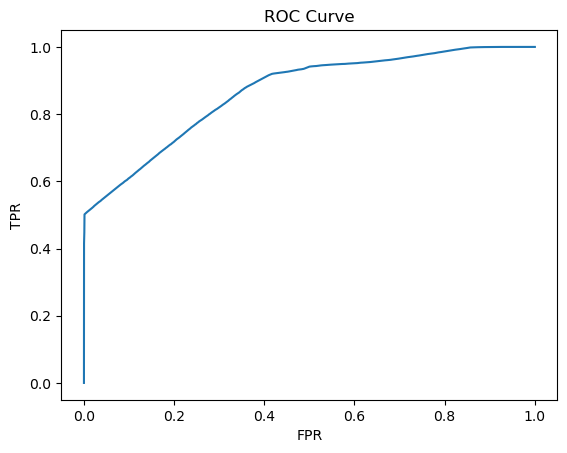

In [52]:
# Create a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Print AUC
print("Area Under ROC: " + str(evaluator.evaluate(rf_prediction, {evaluator.metricName: "areaUnderROC"})))

# Plot ROC curve
rf_model = rf_pipline_model.stages[-1]
training_summary = rf_model.summary
roc = training_summary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.show()

In [53]:
# reference https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


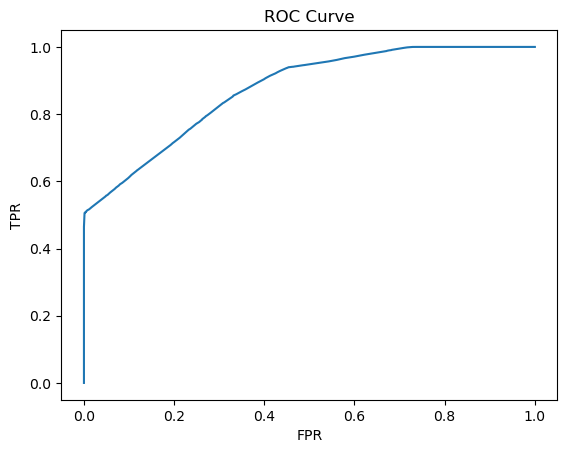

In [54]:
# Returns as a list (false positive rate, true positive rate)
preds = gbt_prediction.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.plot(x_val, y_val)

2.4.3 Save the better model, we will need this for Part B of assignment 2.  
(note: You may need to go through a few training loops or use more data to create a better-performing model.)

In [55]:
# save model
gbt_pipeline_model.save("gbt_pipeline_model")

In [56]:
# release cache
sample_data.unpersist()

DataFrame[num_cat_highvalue: bigint, num_cat_midvalue: bigint, num_cat_lowvalue: bigint, high_value_ratio: double, low_value_ratio: double, is_promotion: string, season: string, gender: string, device_type: string, home_location: string, device_version: string, age: int, first_join_year: int, is_purchase: int, payment_method: string, total_amount: float]

### Part 3. Customer Segmentation and Knowledge sharing with K-Mean <a class="anchor" name="part-3"></a>  
Please see the specification for this task and add code/markdown cells.

**Discussion**
The steps for bulding clustering model as follow:
1. Features selection
2. Evaluate by using Silhouette score, the higher the better.

The cluster model development.
1. Utilized features based on hypothesis.
2. The first model provided Silhouette score 0.7
3. Then find other features that might imporve the score. When consider customer segments problem, total_amount might separate different customer groups, eg. high spender, low spender.
4. For the seccond model the score is 0.94 which mean that total_amount is highly important for customer clustering.

Scaling\
From observation, it suggested that value ranges is highly various. Which indicated that the data might need to be standardised before training model. However, the test score after standardising was decline notably, hence, we will not scaling features for final clustering model.\

Best k groups\
By using various k range from 2 to 9, we can see that k at 2 provides the best Silhouette score 0.94.\

Segmentation recommendation\
The customer groups is mainly defined by bussiness task operation. For example, if the marketing team has budget for 3 customer groups, it will be more suitable to cluster customers in 3 groups.


In [57]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler

In [58]:
# select interested features
selected_features = ["season", "gender", "home_location", "device_version", "age", "total_amount"]

# create new dataframe to select only interested features
cluster_df = feature_df.select(selected_features)
cluster_df =cluster_df.cache()

In [59]:
# endcoding categorical columns
catinput_cols = ["season", "gender", "home_location", "device_version"]
num_cols = ["age", "total_amount"]

# define output cols
catoutput_cols = [f"{col}_index" for col in catinput_cols]

# initiate stages
indexer = StringIndexer(inputCols= catinput_cols, outputCols= catoutput_cols)
encoder = OneHotEncoder(inputCols= catoutput_cols, outputCols= [f"{col}_vec" for col in catinput_cols])
assembler_cat = VectorAssembler(inputCols= [f"{col}_vec" for col in catinput_cols], outputCol= "cat_features")
assembler = VectorAssembler(inputCols= [f"{col}_vec" for col in catinput_cols] + num_cols, outputCol= "features")

In [60]:
# initiate k mean
k_means = KMeans(featuresCol= "features", k= 2, seed=1)

# building pipeline
k_means_pipeline = Pipeline(stages= [indexer, encoder, assembler, k_means])

# fit and transform 
k_means_pipeline_model = k_means_pipeline.fit(cluster_df)
k_means_predictions = k_means_pipeline_model.transform(cluster_df)

In [61]:
# evaluate model
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(k_means_predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.9406262919639817


In [62]:
cluster_df.unpersist()

DataFrame[season: string, gender: string, home_location: string, device_version: string, age: int, total_amount: float]

**Find best k clusster**

In [63]:
# select features vector
features_df = k_means_predictions.select("features")
features_df = features_df.cache()

In [64]:
silhouette_arr=[]

for k in range(2,10):
    k_means= KMeans(featuresCol='features', k=k, seed=1)
    model = k_means.fit(features_df)
    predictions = model.transform(features_df)
    silhouette = evaluator.evaluate(predictions)
    silhouette_arr.append(silhouette)
    print('No of clusters:',k,'Silhouette Score:',silhouette)

No of clusters: 2 Silhouette Score: 0.9406262919639817
No of clusters: 3 Silhouette Score: 0.9096016220581032
No of clusters: 4 Silhouette Score: 0.8870957233741441
No of clusters: 5 Silhouette Score: 0.860237430976455
No of clusters: 6 Silhouette Score: 0.8292810084506833
No of clusters: 7 Silhouette Score: 0.8202442806845425
No of clusters: 8 Silhouette Score: 0.7656152692731623
No of clusters: 9 Silhouette Score: 0.7270845030860182


### Part 4: Data Ethics, Privacy, and Security <a class="anchor" name="part-4"></a>  
Please see the specification for this task and add markdown cells(word limit: 500).

Concepts of data ethics, privacy, and security:
**Data ethics** refers to the practices that aim to preserve all realated partners trust, in context of data management which involves all stages in data life cycle. By ensuring data management aligns with ethical principles and law.
**Privacy** involves collecting and processing personal information in a maner that aligns with customer expectations for security and confidentiality.
**Security** refers to confidentiality, integrity and data availability.

In big data world, it poses serveral security risks that need to address, in order to protect sensitive data for both individual personal and organisation. Some or risks that associated with big data can be refered as follows:
 * Data storage security: it is vital to prevent unauthorized peronal accessing or data leak.
 * Data privacy: protecting personal or corporate information privacy is essential.
 * Data poisoning: hackers or malicious person might attemt to manipulate data input to influence output of big data.
These risks can be prevented by some measures, including:
 * Encyption: Help preventing unauthorised access.
 * Authentication: ensure that only authorised personel can be asscess.
 * Auditing: regulary auditing will help to detect malicious behavior from both inside and outside.

## References:
Please add your references below:

1. apache spark ml - pyspark extract ROC curve? (n.d.). Stack Overflow. https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
2. MLlib: Main Guide - Spark 2.4.4 Documentation. (2019). Apache.org. https://spark.apache.org/docs/latest/ml-guide.html
3. Edquist, A., Grennan, L., Griffiths, S., & Rowshankish, K. (2022, September 23). Data ethics: What it means and what it takes | McKinsey. Www.mckinsey.com. https://www.mckinsey.com/capabilities/mckinsey-digital/our-insights/data-ethics-what-it-means-and-what-it-takes
4. Brown, A. (2020, June 17). Digital Ethics & Privacy: Doing the Right Thing with Data. RGP. https://rgp.com/human-insight/digital-ethics-privacy-doing-the-right-thing-with-data/
5. What is Data Privacy? Definition and Compliance Guide. (n.d.). Talend - a Leader in Data Integration & Data Integrity. https://www.talend.com/uk/resources/data-privacy/
6. Buried under big data: security issues, challenges, concerns. (2018, April 4). Scnsoft.com. https://www.scnsoft.com/blog/big-data-security-challenges
7. Tierney, M. (2021, July 26). Data Security Explained: Challenges and Solutions. Https://Blog.netwrix.com/. https://blog.netwrix.com/2021/07/26/data-security/

‌